Imports 

In [1]:
import numpy as np
from numpy import array
import string

In [2]:
# this function is defined to read the corpus
def sample_corpus(path):

  count = 0
  res = []
  corpus = ''

  with open(path, 'r',encoding="utf8") as ptr:
    for line in ptr:
      res.append(line)


  for i in range(0, len(res)):
    
    if count>500:
      break

    if res[i].startswith("موضوع"):
      count += 1
      continue

    corpus = corpus+ ' ' + res[i].strip()

  return corpus


In [3]:
# Returns an array of words that occurred less than N time in given corpus
def get_rare_words(corpus, N):
  
  tokens = corpus.split()
  
  dict = {}
  
  for word in tokens:
    
    if word in dict:
      dict[word]+=1
    
    else:
      dict[word]=1

  rare_words = []

  for key, value in dict.items():

    if value <= N:
      rare_words.append(key)

  print('count of rare words: ')
  print(len(rare_words))

  return rare_words

In [4]:
# remove punctuation marks, non-alphabetic tokens, and lowercase the tokens
def clean_sentence(sentence):

  tokens = sentence.split()

  translation_table = str.maketrans('', '', "\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~،؟!❊#$٪^&*)(ـ+=-؛:{}")

  tokens = [w.translate(translation_table) for w in tokens]

  tokens = [word for word in tokens if word.isalpha()]

  tokens = [word for word in tokens if word not in rare_words]
  
  return tokens


In [5]:

import pickle

# Read dataset, extract rare-words, split the corpus into sentences, clean each sentence and store the
# cleaned sentences with pickle

USE_SAVED_OBJ = True

# path to dataset
data_path = "dataset.txt"

if (not USE_SAVED_OBJ):
  # read the cotpus as a string
  corpus_raw = sample_corpus(data_path)
  
  # extract the rarewords
  rare_words = get_rare_words(corpus_raw, 1)
  
  # split the input corpus into sentences separated by '.'
  sentences = corpus_raw.split('.')

  tokenized_sentences = []
  
  # clean each sentence and split it into tokens
  for sent in sentences:
    tokens = clean_sentence(sent)
    tokenized_sentences.append(tokens)
  
  # save the cleaned sentences in pickle file
  file = open("corpus.obj","wb")
  pickle.dump(tokenized_sentences,file)
  file.close()

else:
  
  # load the cleaned sentences by pickle from file
  file = open("corpus.obj","rb")
  tokenized_sentences = pickle.load(file)
  file.close()



In [6]:
len(tokenized_sentences)

302

In [7]:
# Extract sequences of N-grams from corpus

# count of given words to predict the next word
window_size = 3

# length of sequence or n-gram
seq_length = window_size + 1

# store the n-grams in sequences list
sequences = list()

# extract a sentence of each 'seq_length' consecutive words from given sentences.
for tokens in tokenized_sentences:
  for i in range(seq_length, len(tokens)):
    seq = tokens[i-seq_length:i]
    line = ' '.join(seq)
    sequences.append(line)

print('Total Sequences: %d' % len(sequences))

Total Sequences: 2890


In [8]:
sequences[1]

'که از صورت بالا'

In [9]:
# model imports 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten
import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:

# create the tokenizer and fit it on the input text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)

# tokenize the sequences into encoded numbers
sequences = tokenizer.texts_to_sequences(sequences)


In [11]:
sequences[5]

[5, 4, 287, 1]

In [12]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [13]:
sequences = array(sequences)

# split the sequence of N-grams into input (x) and output (y)
X, y = sequences[:,:-1], sequences[:,-1]


In [14]:
# convert the output into categorical format required for training the model
y = to_categorical(y, num_classes=vocab_size)


In [15]:
np.shape(y[0])
y[0]
np.shape(X)

(2890, 3)

In [16]:
# split data into train, test, and validation sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

length = int(len(X_test)/2)

y_validation = y_test[0:length]
X_validation = X_test[0:length]

y_test = y_test[length:2*length]
X_test = X_test[length:2*length]


In [17]:
# The PlotLosses function, plots the validation and training loss function during the
#  training to give an insight of training the model


class PlotLosses(keras.callbacks.Callback):
  
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [19]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=window_size, name ='Embedding-layer'))
model.add(Flatten())
model.add(Dense(int(vocab_size/2), activation='relu', name='hidden-layer'))
model.add(Dense(vocab_size, activation='softmax', name='output-layer'))

# print summary of model's structure:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding-layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden-layer (Dense)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output-layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


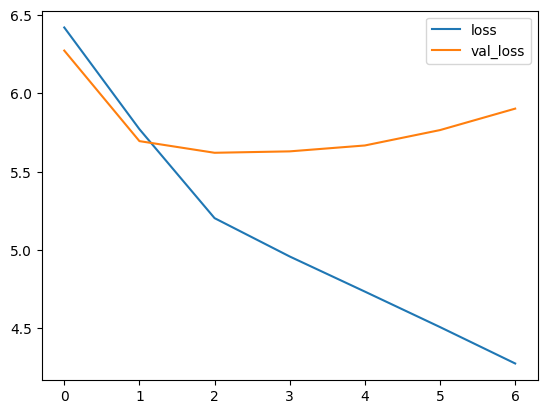

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1297 - loss: 4.2663 - val_accuracy: 0.0917 - val_loss: 5.9026


In [21]:

# define checkpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}--{val_accuracy:03f}.weights.h5', verbose=1, monitor='val_loss',save_best_only=True, 
                             save_weights_only=True, mode='min')  

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, 
          batch_size=50, 
          epochs=7, 
          validation_data=(X_validation, y_validation),
          callbacks=[checkpoint, plot_losses])



In [22]:
# load the best model
best_model_path = 'model-002--0.096886.weights.h5'
model.load_weights(best_model_path)

In [24]:
# predict the class of test data
predict_x=model.predict(X_test[0:200]) 
classes_x=np.argmax(predict_x,axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [25]:
# given the ID of word returns its corresponding word
def convert_ID_to_word(ID):   
  for word, index in tokenizer.word_index.items():
    if index == ID:
      return word
  return 

# given the input sentence as an array of word Ids, returns the string of sentence
def get_sentence_from_IDs(x):
  sent = ''
  for elem in x:
    sent+= convert_ID_to_word(elem) + ' '
  return sent

In [27]:
res = classes_x

In [28]:
arr = [0,6, 13, 14, 17, 18, 22, 35, 53, 73, 105, 112, 124, 128, 137, 145, 154, 161, 185]
for i in arr:
  print( get_sentence_from_IDs(X_test[i]) +' : '+convert_ID_to_word(res[i]))

بدانم که این  : و
مناطق کووید جایزۀ  : و
از مردم مسلمان  : و
به و تا  : و
طرفین درگیر را  : و
که به واژه  : و
جریان که از  : و
خود توجیه کنند  : و
بیشتر را اما  : و
توجه کنید که  : و
که در سودان  : و
داشته باشید به  : و
را دنبال کنند  : و
است که در  : و
در سودان بر  : و
این است که  : و
نه و و  : و
محلی از در  : و
اما میزان ناشی  : و
